## Comparing different methods of accelerating numerical python code

A little while ago there was a [post][1] on [/r/rust][2] describing huge gains in porting some numerical code from python to rust. The gains were impressive, but as someone who has worked with python for a long time, I know it's pretty easy to write really slow python. There are a number of options within the ecosystem to get more performant code, and how effective the strategy is highly depends on the nature of the bottleneck. 

One place where the options are good is anytime you have to do operations on arrays. Sometimes there is a way to hand off the calculation to [numpy](https://numpy.org/), which uses highly optimized C under the hood (i.e. vectorized or "broadcasting" solutions). In other cases you can write a C-extension with [cython](https://cython.org/), or use a JIT like [numba](https://numba.pydata.org/) that can generate very fast code for a subset of python/numpy operations. There are a ton of other tools including [pythran](https://pythran.readthedocs.io/en/latest/), [numexpr](https://github.com/pydata/numexpr) and others. All of these have limitations and won't just automatically get you fast code, but they often work very well for these types of numerical bottlenecks.

Since I've been playing around with rust on and off for the last few years and you can write extension modules with rust for python, I was curious to compare it to these other more common solutions. I'm not a rust expert, but I've worked through many of the exercism.io problems on the rust track and used it for Advent of Code 2020, as well as a few side projects -- mostly processing hundreds of GB of xml and json files, where rust was 5-10x faster than my python prototype. So I'm not an expert, but am not a complete novice either. 

### Defining a test problem

So here's the problem I'm going to benchmark with a bunch of different tools. Let's take a 5-dimensional array where all dimensions are of an equal length `N` (so shape `(N, N, N, N, N)`). What I want to calculate is a new array of the same shape where the value at element `(i, j, k, l, m)` given `i < j < k < l < m` is the sum of all elements with those same indices permuted in any order. All other elements either with repeating indices and/or unsorted indices should be zero. A simple python implementation of this would be:

```python
import itertools
import numpy as np

def accum_unordered(x):
    g = np.zeros(x.shape)
    for ix in itertools.permutations(range(x.shape[0]), 5):
        g[tuple(sorted(ix))] += x[ix]

    return g
```

This is a toy problem but it involves a large number of arithmetic operations on arrays and does not vectorize easily due to the pattern of elements that are being accumulated. 

**General Caveats**
- This is a toy problem and results should not be taken to be generalizable. Your results for different tools will likely differ on different problems and possibly even different hardware.
- I'm not going to extreme measures to eek out performance. Therefore I'm probably missing optimization strategies. I'm going more for the "what can I accomplish given a few hours in an afternoon". 

### Implementations

The code snippet above is what I'll call the reference python implementation since it's compact and uses python standard library tools outside of using a `numpy` array as the data structure. Below I'm going to go through a number of different implementations and then I'll benchmark each for different sizes of test arrays defined like:

```python
N = 16
a = np.random.normal(size=(N, N, N, N, N))
```

All code is available in the same github repository as this notebook:
https://www.github.com/synapticarbors/ndarray_comparison

I'm including a README there on how to compile the code, which I'm assuming has been done before attempting to import any implementation.

[1]: https://www.reddit.com/r/rust/comments/qjxwni/we_just_massively_overdelivered_on_a_project/
[2]: https://reddit.com/r/rust

#### Vectorized Numpy Solution

This problem can't be efficiently cast in terms of a vectorized operations, but we'll still give it a go. We're going to permute the axis of the input array, sum all elements and then keep only the ones we want:

```python
def accum_unordered_vec(x):
    y = np.zeros(x.shape)
    for ix in itertools.permutations(range(5), 5):
        y += np.moveaxis(x, [0, 1, 2, 3, 4], ix)

    z = np.zeros(x.shape)
    for ix in itertools.combinations(range(x.shape[0]), 5):
        z[ix] = y[ix]

    return z
```

In [1]:
import numpy as np

from npfunc import accum_unordered, accum_unordered_vec

N = 12
a = np.random.normal(size=(N, N, N, N, N))

x1 = accum_unordered(a)
x2 = accum_unordered_vec(a)

# Check to make sure the solutions are equivalent
print('soln match: ', np.allclose(x1, x2))

%timeit x = accum_unordered(a)
%timeit x = accum_unordered_vec(a)

soln match:  True
78.2 ms ± 988 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
48.9 ms ± 1.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


So for `N = 12` the vecotrized solution is 60% faster. Let's also look when `N` is larger.

In [2]:
N = 24
a = np.random.normal(size=(N, N, N, N, N))

%timeit x = accum_unordered(a)
%timeit x = accum_unordered_vec(a)

4.41 s ± 207 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.66 s ± 207 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


The vectorized solution is still a little faster, but not by much. 

#### Numba

Numba provides a JIT that translates a subset of python and numpy into llvm and then compiles it to machine code. It often involves just adding a decorator to a python function. It tends to be the first thing I try when trying to speed up an array calculation since it is so simple to use. I'm going to rewrite the algorithm using explicit loops since numba doesn't know how to convert methods from `itertools`. I'm also going to write a specialized sort routine for the 5 indices since the `sort` method was translated into some very inefficient code:

```python
import numba as nb
import numpy as np


@nb.jit(nopython=True)
def fast_sort5(a, b, c, d, e):
    "Sort 5 values with 7 Comparisons"
    if a < b:
        a, b = b, a
    if c < d:
        c, d = d, c
    if a < c:
        a, b, c, d = c, d, a, b
    if e < c:
        if e < d:
            pass
        else:
            d, e = e, d
    else:
        if e < a:
            c, d, e = e, c, d
        else:
            a, c, d, e = e, a, c, d
    if b < d:
        if b < e:
            return b, e, d, c, a
        else:
            return e, b, d, c, a
    else:
        if b < c:
            return e, d, b, c, a
        else:
            return e, d, c, b, a


@nb.jit(nopython=True)
def nb_accum_unordered(x):
    n = x.shape[0]
    g = np.zeros(x.shape)

    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            for k in range(n):
                if i == k or j == k:
                    continue
                for l in range(n):
                    if i == l or j == l or k == l:
                        continue
                    for m in range(n):
                        if i != m and j != m and k != m and l != m:
                            ix, jx, kx, lx, mx = fast_sort5(i, j, k, l, m)
                            g[ix, jx, kx, lx, mx] += x[i, j, k, l, m]

    return g
```

In [3]:
from nbfunc import nb_accum_unordered

N = 12
a = np.random.normal(size=(N, N, N, N, N))

x1 = accum_unordered(a)  # our reference python solution
x2 = nb_accum_unordered(a)  # numba 
x3 = nb_accum_unordered.py_func(a)  # the same code as the numba but without the JIT

# Check to make sure the solutions are equivalent
print('soln match: ', np.allclose(x1, x2), np.allclose(x1, x3))

%timeit x = accum_unordered(a)
%timeit x = nb_accum_unordered(a)
%timeit x = nb_accum_unordered.py_func(a)

soln match:  True True
80.2 ms ± 2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
994 µs ± 22.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
103 ms ± 2.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


So our numba solution is 76x faster than the python reference. The explicit looping implementation that isn't compiled is 25% slower than the reference so it's not that the algorithm is faster, it's the JIT compilation. Let's check again for a larger test array:

In [4]:
N = 24
a = np.random.normal(size=(N, N, N, N, N))

%timeit x = accum_unordered(a)
%timeit x = nb_accum_unordered(a)

4.24 s ± 58.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
53.7 ms ± 1.95 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### Cython

With cython we write an optional hybrid of C and Python that get's translated to C code and then compiled. It's a bit of it's own language, but essentially I'm going to use the algorithm I used with numba, but just add types. I'm also going to add a compiler directive to drop bound checks on the arrays since we know that for a correctly shaped input, we're never going to have an out-of-bounds access. Numba has bounds checking turned off by default. I'm not goint to copy the code here, but it's in `cyfunc.pyx`.

In [5]:
from cyfunc import cy_accum_unordered

N = 12
a = np.random.normal(size=(N, N, N, N, N))

x1 = accum_unordered(a)  # our reference python solution
x2 = cy_accum_unordered(a)  # cython

# Check to make sure the solutions are equivalent
print('soln match: ', np.allclose(x1, x2))

%timeit x = accum_unordered(a)
%timeit x = cy_accum_unordered(a)


soln match:  True
79.8 ms ± 1.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.09 ms ± 26 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


So the cython implementation is a little more verbose because of the added type declarations, but we get very similar performance to numba. 

#### Pythran

I hadn't used pythran before this experiment, but it seemed nearly as simple as numba in terms of code changes, but you still need to set up compilation since it's an ahead-of-time python to C++ translator, that produces native C++11 code with a wrapper to allow it to be called from python. The in-code change from numba only involved dropping the `nb.jit` decorators and adding the following comment above the function definition:

```python
#pythran export pthr_accum_unordered(float64[:,:,:,:,:] order(C))
def pthr_accum_unordered(x):
    n = x.shape[0]
    ...
```

In [6]:
from pythranfunc import pthr_accum_unordered

N = 12
a = np.random.normal(size=(N, N, N, N, N))

x1 = accum_unordered(a)  # our reference python solution
x2 = pthr_accum_unordered(a)  # pythran

# Check to make sure the solutions are equivalent
print('soln match: ', np.allclose(x1, x2))

%timeit x = accum_unordered(a)
%timeit x = pthr_accum_unordered(a)

soln match:  True
79.2 ms ± 1.19 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
780 µs ± 12.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


I was pretty surprised and impressed by this. Pythran was 96x faster than the reference python solution and about 30% faster than numba or cython. 


#### Rust

For rust I'm using [PyO3](https://pyo3.rs/) to generate a wrapper around rust code written with [rust-numpy](https://github.com/PyO3/rust-numpy) and the [ndarray](https://docs.rs/ndarray) crate. Since I'm less experienced with rust and these crates in particular, I leaned heavily on the examples and [ndarray for numpy users guide](https://docs.rs/ndarray/0.15.3/ndarray/doc/ndarray_for_numpy_users/index.html). The documentation says specifically to "..prefer higher order methods and arithmetic operations on arrays first, then iteration, and as a last priority using indexed algorithms." I'm not sure if there is a way to get around using "indexed" algorithms here, but as a general comparison I'm going to translate the numba code to rust. I did try writing versions using the `itertools` crate, as well as `.indexed_iter()`, but those were uniformly slower. I also tried a version using `sort_unstable` instead of my custom `fast_sort5`, but that was slower. 

The code looks like:

```rust
fn _accum_unordered1(x: ArrayView5<f64>) -> Array5<f64> {
    let mut g = Array::zeros(x.raw_dim());

    for i in 0..x.len_of(Axis(0)) {
        for j in 0..x.len_of(Axis(1)) {
            if i == j {
                continue;
            }
            for k in 0..x.len_of(Axis(2)) {
                if i == k || j == k {
                    continue;
                }
                for l in 0..x.len_of(Axis(3)) {
                    if i == l || j == l || k == l {
                        continue;
                    }
                    for m in 0..x.len_of(Axis(4)) {
                        if i != m && j != m && k != m && l != m {
                            let (ix, jx, kx, lx, mx) = fast_sort5(i, j, k, l, m);
                            g[[ix, jx, kx, lx, mx]] += x[[i, j, k, l, m]];
                        }
                    }
                }
            }
        }
    }

    g
}

```

and the wrapper code:

```rust
    // wrapper of `_accum_unordered1`
    #[pyfn(m)]
    #[pyo3(name = "rs_accum_unordered1")]
    fn accum_unordered1_py<'py>(py: Python<'py>, x: PyReadonlyArray5<f64>) -> &'py PyArray5<f64> {
        let x = x.as_array();
        _accum_unordered1(x).into_pyarray(py)
    }
```

In [7]:
from rust_ext._rsfunc import rs_accum_unordered1

N = 12
a = np.random.normal(size=(N, N, N, N, N))

x1 = accum_unordered(a)  # our reference python solution
x2 = rs_accum_unordered1(a)  # rust

# Check to make sure the solutions are equivalent
print('soln match: ', np.allclose(x1, x2))

%timeit x = accum_unordered(a)
%timeit x = rs_accum_unordered1(a)

soln match:  True
79.2 ms ± 2.05 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.62 ms ± 14.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


This was a bit disappointing since it's about 60% slower than either the numba or cython solution. I had a feeling though that the rust compiler might have been performing bound checks for the indexed access to the input and output arrays, even though we know that it should be ok. To test this I resorted to some **unsafe rust**:

```rust
fn _accum_unordered5(x: ArrayView5<f64>) -> Array5<f64> {
    let mut g = Array::zeros(x.raw_dim());

    for i in 0..x.len_of(Axis(0)) {
        for j in 0..x.len_of(Axis(1)) {
            if i == j {
                continue;
            }
            for k in 0..x.len_of(Axis(2)) {
                if i == k || j == k {
                    continue;
                }
                for l in 0..x.len_of(Axis(3)) {
                    if i == l || j == l || k == l {
                        continue;
                    }
                    for m in 0..x.len_of(Axis(4)) {
                        if i != m && j != m && k != m && l != m {
                            let (ix, jx, kx, lx, mx) = fast_sort5(i, j, k, l, m);
                            unsafe {
                                *g.uget_mut([ix, jx, kx, lx, mx]) += x.uget([i, j, k, l, m]);
                            };
                        }
                    }
                }
            }
        }
    }

    g
}
```

Here I'm using the "unchecked" methods for array access. This is ok here since I'm in full control of the inputs and I know that the indices are always ok.

In [8]:
from rust_ext._rsfunc import rs_accum_unordered5

N = 12
a = np.random.normal(size=(N, N, N, N, N))

x1 = accum_unordered(a)  # our reference python solution
x2 = rs_accum_unordered5(a)  # rust unsafe array access

# Check to make sure the solutions are equivalent
print('soln match: ', np.allclose(x1, x2))

%timeit x = accum_unordered(a)
%timeit x = rs_accum_unordered5(a)

soln match:  True
76.1 ms ± 1.45 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
803 µs ± 5.38 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


We get a performance increase as expected, and the rust code is now ~20-25% faster than our numba and cython solutions and only about 5% slower than pythran. We had to resort to using an *unsafe* block to remove the penalty for bounds checking though. 

Finally lets collect data for different size arrays.

In [9]:
# This takes a while to run
data = []
arr_sz = [5, 10, 15, 20, 25, 30, 40]

methods = [
    ('pyref', accum_unordered), 
    ('pyvec', accum_unordered_vec), 
    ('numba', nb_accum_unordered), 
    ('cython', cy_accum_unordered),
    ('pythran', pthr_accum_unordered),
    ('rust', rs_accum_unordered1),
    ('rust_unsafe', rs_accum_unordered5)
]

for N in arr_sz:
    for func_name, func in methods:
        print(f'\r{N:02d} {func_name:15}', end='')
        a = np.random.normal(size=(N, N, N, N, N))
        r = %timeit -q -r3 -o x = func(a);
        data.append({'name': func_name, 'n': N, 'timing': r.average})

40 rust_unsafe    

In [10]:
import pandas as pd

df = pd.DataFrame(data)
df = pd.merge(df, df.query('name == "pyref"')[['n', 'timing']], 
              how='left', on=['n'], suffixes=['', '_ref'])
df['speedup'] = df['timing_ref'] / df['timing']

In [11]:
df_spdup = df[['name', 'n', 'speedup']].pivot(index='n', columns='name').round(1)
df_spdup

speedup                                            
name  cython numba pyref pythran pyvec  rust rust_unsafe
n                                                       
5        9.6  28.5   1.0    38.6   0.1  29.5        36.3
10      61.7  63.2   1.0    73.2   1.2  40.8        72.3
15      80.9  87.8   1.0   111.1   1.4  47.8       110.3
20      71.5  81.6   1.0   110.6   1.3  46.1       107.0
25      76.7  85.1   1.0   113.2   1.1  47.5        99.6
30      65.5  63.0   1.0   141.5   1.0  54.1       135.5
40      60.1  57.8   1.0   119.2   0.7  49.5       119.8

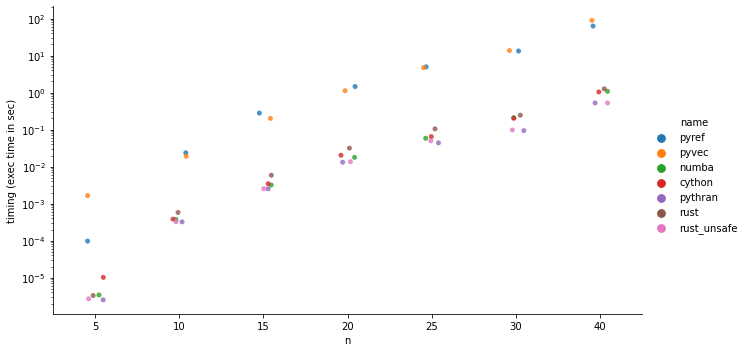

In [24]:
import seaborn as sns
%matplotlib inline

g = sns.catplot(x='n', y='timing', hue='name', 
                alpha=0.8, jitter=0.1, aspect=1.8, data=df)
g.set(yscale="log")
g.set(ylabel="timing (exec time in sec)")

The numba and cython solutions gave about the same speed-up, with numba perhaps slightly faster. The nice thing about numba is that you don't have to add a compilation step to your workflow. It's done in a JIT fashion and then the machine code is cached in memory. This works well if you have a long running process, but you do pay a runtime startup cost. There is an [option](https://numba.readthedocs.io/en/stable/user/jit.html#cache) to cache the compilation to disk which helps though. 

The safe rust implementation fell in behind numba and cython, but the unsafe version was pretty much on-par with the pythran implementation. I need to look into why all of the implementations' performance fell off at higher `N` relative to the reference and why that fall off happened earlier for numba and cython. Cython also appears to have something going on for the small array (`N=5`) case, where it's performance is poor relative to the other methods. This might be some sort of overhead in the wrapper that's generated or the cost of acquiring the array's memory buffer, but I'm not sure.

### Conclusion

When writing numerical algorithms over n-dimensional arrays in python there are a number of tools available to deal with performance bottlenecks. I've tested a toy example here with a few of the more popular ones and also using a rust-extension. I'm not sure if I've come up with the "best" implementation for this particular problem, but I think it provides a pretty fair comparison between the various tools. 

Existing tools from the python ecosystem can give you performance that's similar to what you might get writing the same algorithm in rust and can probably beat it if you don't pay attention to the cost of bounds checking. I particular like numba given its simplicity and not needing to rig up a compilation step. I'm hoping someone who looks at my first pass at this has ideas about how to force the rust compiler to ellide the bounds check by doing something clever rather than writing unsafe code. 

That said, working with pyO3/ndarray/rust-numpy seemed pretty easy so I can imagine instances where I would want to either do a complete project in rust or shove more of the task down to the rust extension level where you can take advantage of the rust crate ecosystem, memory/threading safety and the speed of compiled code involving more complex data structures. As a rule-of-thumb to get the best performance you want to cross the interface between python and compiled code as little as possible, so the more you can do before returning to python, the better. 

Feedback is welcome and if I get any good suggestions on improving the code, I'll add it to the benchmark.

In [21]:
%load_ext watermark

In [22]:
%watermark -iv -m
# running on a mid-2014 MacBook Pro
# 2.5 GHz Intel Core i7
# 16 GB 1600 MHz DDR3

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 18.7.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit

pythran: 0.10.0
seaborn: 0.11.2
pandas : 1.3.4
numba  : 0.54.1
cython : 0.29.24
numpy  : 1.20.3



### Edits
- Nov-11-2021: Changed looping implementations so nesting wasn't as deep for visual clarity. Changed plot to make all data points more visible.